# Are serum cholesterol levels and resting blood pressure good predictors leading to high accuracy for a model aiming to predict whether individuals have exercise-induced angina?

By: Yuuta L., Wendi L., Ella T., Toma V.

## Introduction

### Background Information
An angina is a common symptom of cardiovascular disease. It occurs when parts of the heart are not sufficiently supplied with oxygenated blood as a result of atherosclerosis (NHLBI, 2023). Atherosclerosis is the build-up of plaque in arteries usually caused by high levels of cholesterol that accumulate on artery walls, triggering an immune response. White blood cells attempt to clear the build-up but cling to the walls, forming a growing lump that permanently stays in place (Harvard Health, 2023). As a result, fewer red blood cells carrying oxygen are able to pass through the artery at once. Exercise-induced angina occurs as heart rate increases during exercise to supply more oxygen to the cells in need, inducing chest pain. The higher demand in oxygen and restricted supply due to the shrunken diameter of the artery leads to cardiac cell death (Heart and Stroke Canada). 

We strive for our model to predict the presence of an exercise induced angina for random individuals, taking into account their resting blood pressure as well as their cholesterol levels measured in dl/mg. Using its accuracy, we are interested in finding out how useful such a model would be useful in a clinical setting. 

### Research Question
**Are serum cholesterol levels and resting blood pressure good predictors leading to high accuracy for a model aiming to predict whether individuals have exercise-induced anginas?**

### Dataset
Our dataset is a 1988 heart disease dataset from Kaggle (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). We used a pre-processed version of the dataset from https://archive.ics.uci.edu/dataset/45/heart+disease for better data analysis and readability. The dataset contains 17 variables relating to cardiovascular health as well as information about the patients such as age and sex. The definition of column names of the original dataset and the Kaggle dataset can be found on their respective websites.

To answer our predictive question, we will use columns `trestbps` (Resting blood pressure, measured in mm Hg) and `chol` (Serum cholesterol, in mg / dL) to predict `exang` (Exercise induced angina). 

## Methods

The steps towards our result include:
1. Import the dataset into R.
2. Wrangle the dataset by converting response variable values to factor values.
3. Numerically summarize the training dataset.
4. Visualize the training dataset.
5. Perform the data analysis using K-nearest-neighbors.
6. Visualize the data analysis using scattter plots.

### Import data into R and wrangle the data

First, we loaded the libraries, installed the K-nearest-neighbors package, and set the seed.

In [1]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)
# Install the K-nearest-neighbors package
install.packages("kknn")
library("kknn")
# Set the seed
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Then, we imported the data from our data set into R from a link to the .csv file in our GitHub repository.

In [2]:
# Download the .csv file from our GitHub repository and parse it
heart_data_raw <- read_csv("https://raw.githubusercontent.com/L-Wendi/dsci-100-project/main/heart.csv")

head(heart_data_raw)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


*Table 1: The heart disease dataset imported into R*

To answer our predictive question, we will use three columns:

1. `trestbps`: Resting blood pressure, measured in mm Hg (predictor).
2. `chol`: Serum cholesterol, in mg / dL (predictor).
3. `exang`: Exercise induced angina (target variable).

The original dataset has `exang` as `<dbl>` type. We wrangled the data, renaming these fields to have meaningful `<fct>` types. To further clean the data, we only kept the relevant columns: `trestbps`, `chol`, and `exang`.

In [3]:
heart_data <- heart_data_raw |>
    mutate(exang = fct_recode(as_factor(exang), "Yes" = "1", "No" = "0")) |>
    select(trestbps, chol, exang)

head(heart_data)

trestbps,chol,exang
<dbl>,<dbl>,<fct>
125,212,No
140,203,Yes
145,174,Yes
148,203,No
138,294,No
100,248,No


*Table 2: The cleaned and wrangled data necessary for our exploration*

### Exploratory data summary

We made a summary of the predictors based on training data using the three columns of interest (`trestbps`, `chol`, and `exang`). First, we split the initial dataset into training set ($75\%$) and testing set ($25\%$), based on our target variable, `exang`. We will summarize the exploratory data based on the training dataset only, because the testing dataset will not be used until the final prediction.

In [4]:
# Set the seed for every cell requiring randomization to make it reproducible.
set.seed(1)

# Split the data into training and testing sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = exang)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

# Verify the split by counting the number of rows in each set
nrow(heart_training)
nrow(heart_testing)

[1] 768

[1] 257

After splitting the datasets, we performed a summary of the exploratory data. We group the training data based on whether the patient has exercise induced angina (`exang`, the target variable), and then we summarized the mean as well as the minimum and maximum values of both predictors.

In [5]:
heart_predictors_info <- heart_training |>
    select(exang, trestbps, chol) |>
    group_by(exang) |>
    summarize(count = n(),
              mean_trestbps = mean(trestbps), max_trestbps = max(trestbps), min_trestbps = min(trestbps),
              mean_chol = mean(chol), max_chol = max(chol), min_chol = min(chol))

heart_predictors_info

exang,count,mean_trestbps,max_trestbps,min_trestbps,mean_chol,max_chol,min_chol
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,510,130.9902,192,94,241.6255,564,126
Yes,258,132.3915,200,94,249.0039,409,131


*Table 3: The count and mean / max / min values for two predictor variables vs. the target variable in the training dataset.*

### Exploratory data visualization

In the exploratory data analysis, we also drew a scatter plot based on training data to visualize the relationship between resting blood pressure and serum cholesterol, along with the presence of angina.

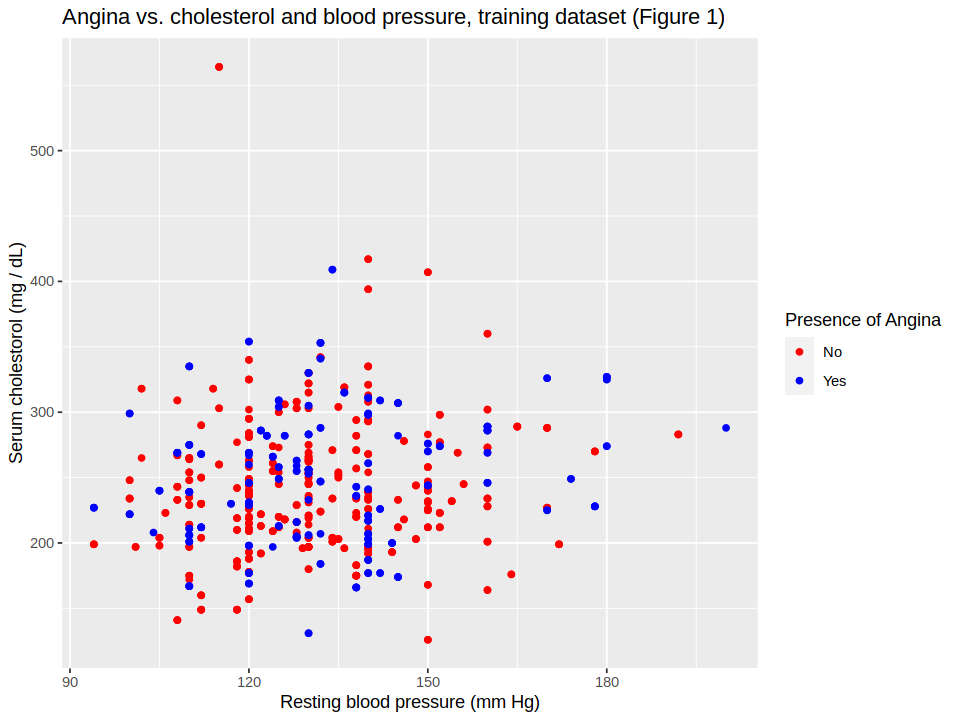

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6)

heart_training |> ggplot(aes(x = trestbps, y = chol, color = exang)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", color = "Presence of Angina") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, training dataset (Figure 1)")

To emphasize on the correlation between the two predictor variables and the target variable, we draw two different bar plots comparing each of them to the target variable. The first one (Figure 2) is for cholesterol, and the second one (Figure 3) is for blood pressure. We chose bar plots over histograms because bar plots can show the percentage within each subfigure while histograms can only show the identity. We want percentages because the `exang = TRUE` and `exang = FALSE` are not $1 : 1$.

Warning message:
“Removed 33 rows containing non-finite values (`stat_count()`).”


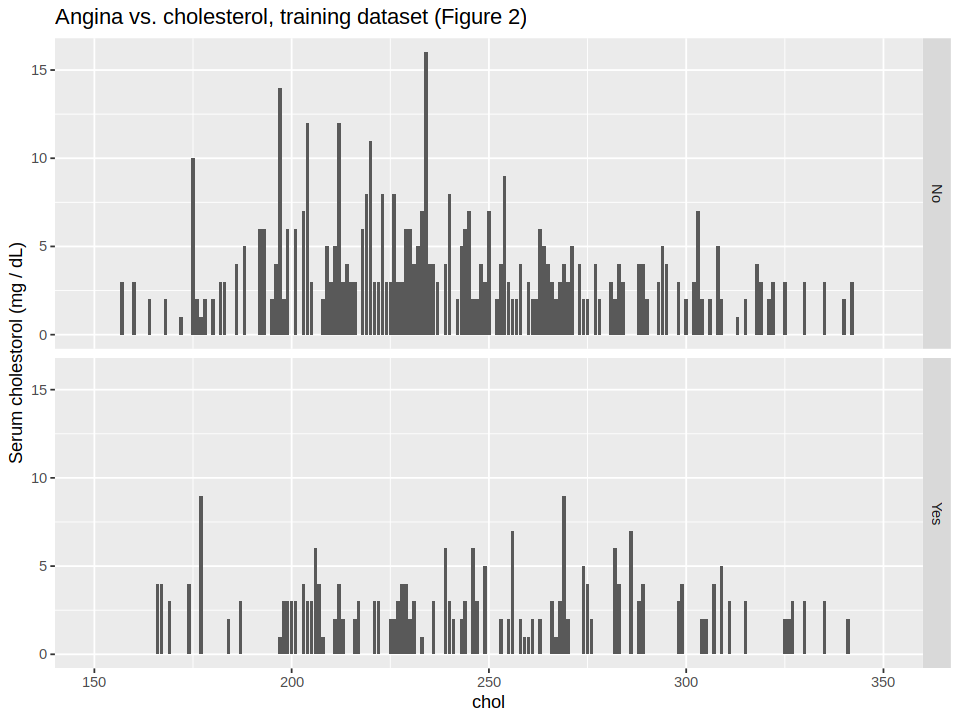

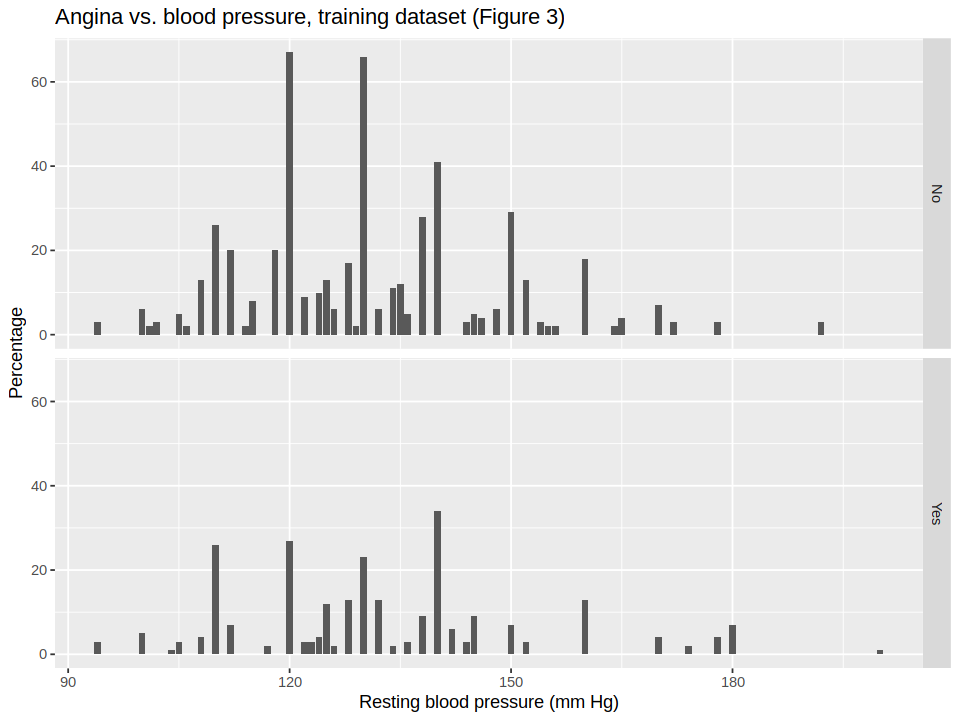

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)

heart_training |> ggplot(aes(x = chol)) +
    geom_bar()  +
    labs(y = "Serum cholestorol (mg / dL)", y = "Percentage") +
    scale_color_manual(values = c("red", "blue")) +
    facet_grid(rows = vars(exang)) +
    ggtitle("Angina vs. cholesterol, training dataset (Figure 2)") +
    xlim(c(150, 350))

heart_training |> ggplot(aes(x = trestbps)) +
    geom_bar()  +
    labs(x = "Resting blood pressure (mm Hg)", y = "Percentage") +
    scale_color_manual(values = c("red", "blue")) +
    facet_grid(rows = vars(exang)) +
    ggtitle("Angina vs. blood pressure, training dataset (Figure 3)")

### Data analysis

To answer our predictive question, we will be using K-nearest neighbors to build a classifier that predicts if the patient experiences exercise induced angina. The variables used as predictors are the resting blood pressure (`trestbps`) and serum cholesterol levels (`chol`). The response variable is the categorical variable for exercised induced angina (`exang`). This involves three steps:

1. Create a recipe for the training data.
2. Perform a cross-validation to determine the optimal $K$ value.
3. Use the model to perform the actual K-nearest-neighbors classification.
4. Collect the metrics.

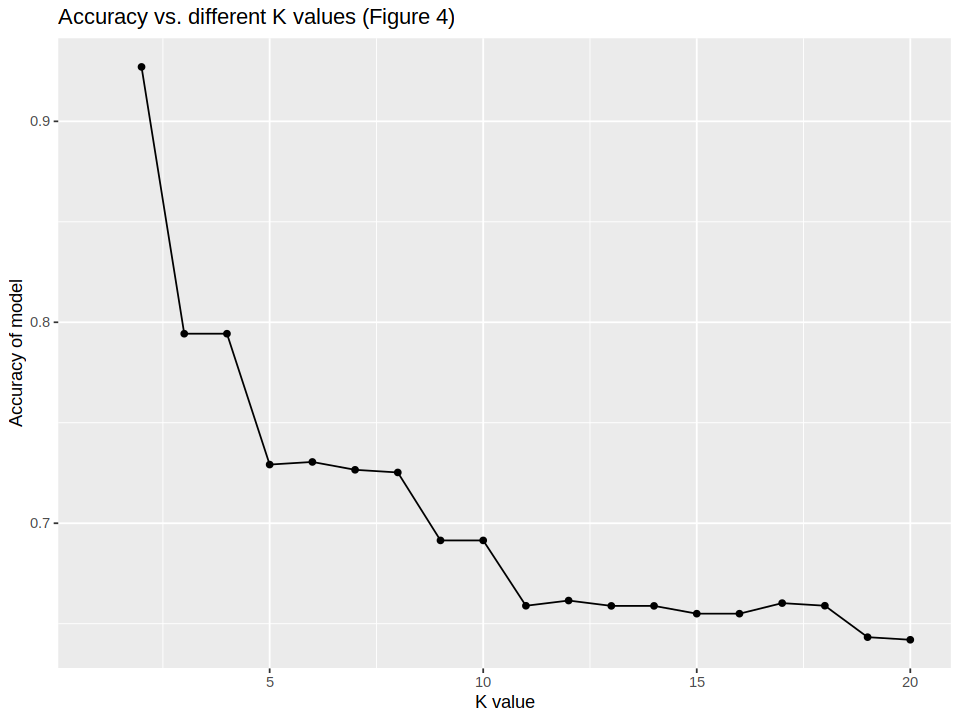

In [8]:
# Set the seed for every cell requiring randomization to make it reproducible.
set.seed(1)

# 1. Create a recipe to standarize the training data.
heart_recipe <- recipe(exang ~ trestbps + chol, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2.1: Create a KNN model specification for cross-validation.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
# 2.2: Perform cross-validation with five folds.
vfold <- vfold_cv(heart_training, v = 5, strata = exang)
# 2.3: Perform cross-validation with K from 2 to 20.
gridvals <- tibble(neighbors = seq(from = 2, to = 20))
# 2.4: Execute the cross-validation and collect results.
wkflw <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics()
# 2.5: Plot the accuravy vs. K line plot
results <- wkflw |>
    filter(.metric == "accuracy")
k_plot <- results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K value", y = "Accuracy of model") +
    xlim(1, 20) +
    ggtitle("Accuracy vs. different K values (Figure 4)")
k_plot

We chose $K = 3$ based on the graph in Figure 4 because the very high accuracy of $K = 2$ would risk overfitting, $K = 3$ has a slightly higher accuracy than $K = 4$, and $K = 3$ is odd which works well for our classification having only $2$ categories.

We used $K = 3$ to create the final K-nearest-neighbors model specification, then trained it using the training data. Then we used this classification model to predict on our testing set.

In [9]:
# Set the seed for every cell requiring randomization to make it reproducible.
set.seed(1)

# 3.1: Create a KNN spec for final prediction
knn_3_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

# 3.2: Train the final model using training data
heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_3_spec) |>
    fit(data = heart_training)

# 3.3: Predict on the testing set
heart_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

head(heart_predictions)

.pred_class,trestbps,chol,exang
<fct>,<dbl>,<dbl>,<fct>
Yes,122,286,Yes
No,140,308,No
Yes,140,211,No
Yes,140,185,No
No,106,223,No
No,136,319,No


*Table 4: The predictions of the testing set*

Finally, we collect the metrics of the prediction and created a confusion matrix to determine the model's accuracy, precision, and recall.

In [10]:
# 4.1: Collect metrics to determine model accuracy
model_accuracy <- heart_predictions |>
    metrics(truth = exang, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

# 4.2: Create a confusion matrix to determine model precision and recall
heart_conf_mat <- heart_predictions |>
    conf_mat(truth = exang, estimate = .pred_class)
heart_conf_mat

model_precision <- 66 / (14 + 66)
model_recall <- 66 / (21 + 66)

          Truth
Prediction  No Yes
       No  156  21
       Yes  14  66

*Table 5: The confusion matrix of the dataset*

In [11]:
# 4.3: Summary of metrics
metrics <- tibble(accuracy = model_accuracy, precision = model_precision, recall = model_recall)
metrics

accuracy,precision,recall
<dbl>,<dbl>,<dbl>
0.8638132,0.825,0.7586207


*Table 6: The metrics of accuracy / precision / recall of the model*

### Visualize results

To effectively visualize the data analysis, we continued to use scatter plots of predictors variables vs. the predicted target variable. Readers can identify the two predicted categories by the different colors, with no presence of angina in red and the presence of angina in blue.

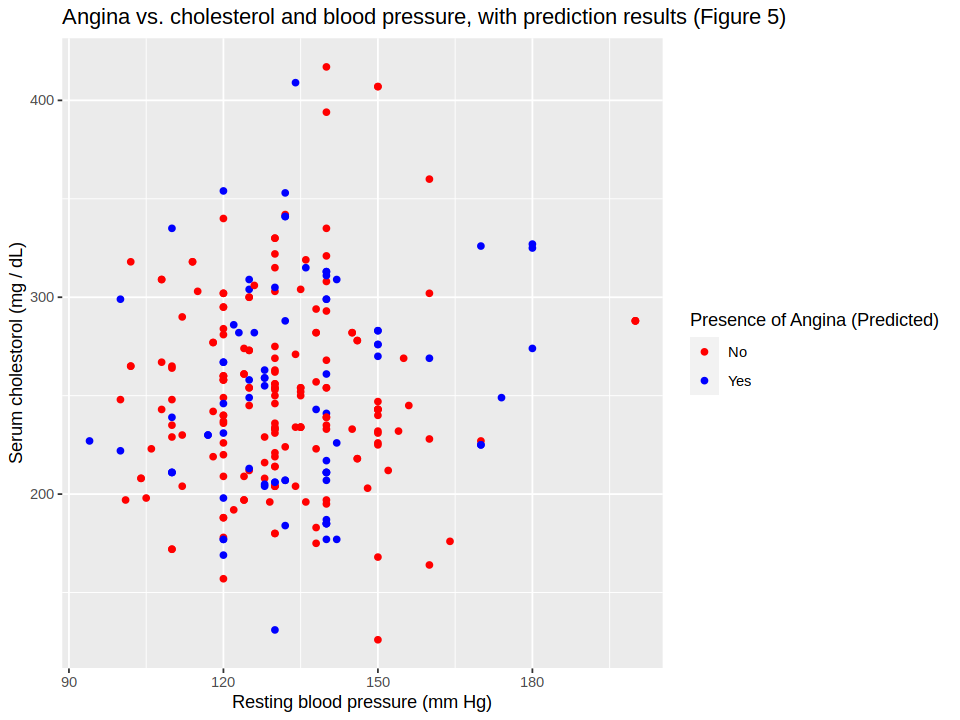

In [12]:
options(repr.plot.width = 8, repr.plot.height = 6)

heart_predictions |> ggplot(aes(x = trestbps, y = chol, color = .pred_class)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", color = "Presence of Angina (Predicted)") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, with prediction results (Figure 5)")

We did the same bar graphs for the prediction result, to show the correlations between the two predictor variables and the target variable.

Warning message:
“Removed 10 rows containing non-finite values (`stat_count()`).”


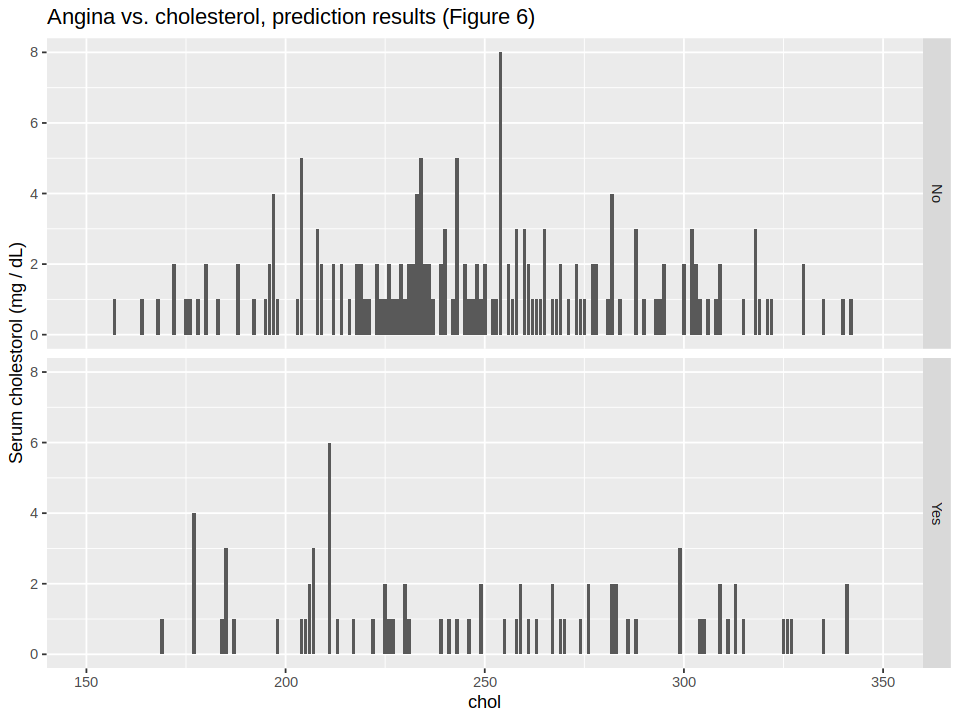

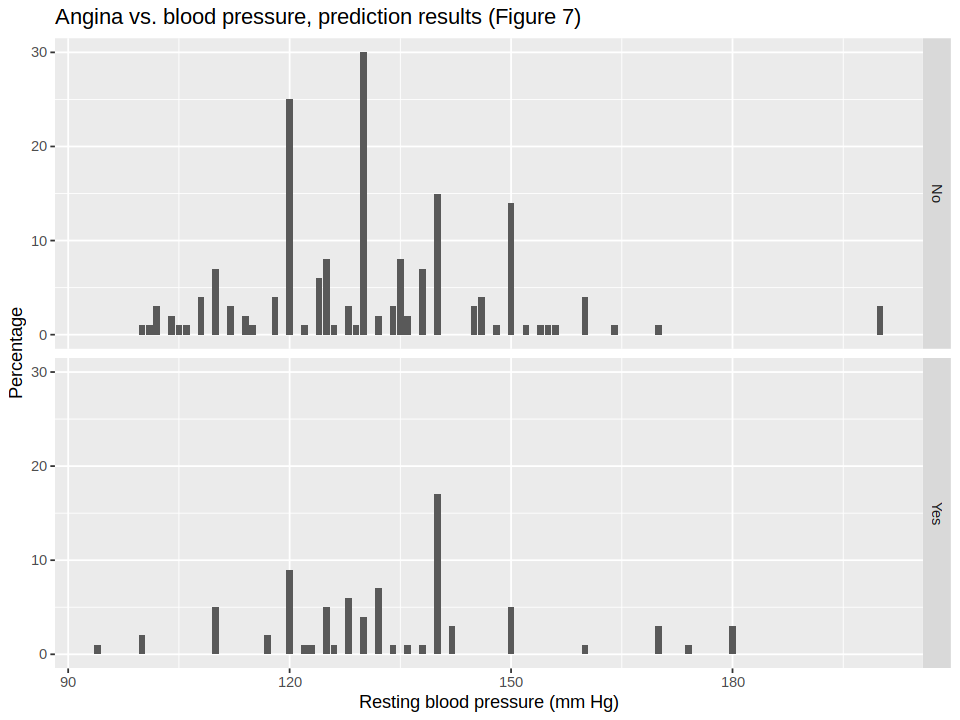

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)

heart_predictions |> ggplot(aes(x = chol)) +
    geom_bar()  +
    labs(y = "Serum cholestorol (mg / dL)", y = "Percentage") +
    scale_color_manual(values = c("red", "blue")) +
    facet_grid(rows = vars(.pred_class)) +
    ggtitle("Angina vs. cholesterol, prediction results (Figure 6)") +
    xlim(c(150, 350))

heart_predictions |> ggplot(aes(x = trestbps)) +
    geom_bar()  +
    labs(x = "Resting blood pressure (mm Hg)", y = "Percentage") +
    scale_color_manual(values = c("red", "blue")) +
    facet_grid(rows = vars(.pred_class)) +
    ggtitle("Angina vs. blood pressure, prediction results (Figure 7)")

In addition, in order to show the accuracy of our data analysis, we used different colors to indicate whether the prediction is correct or not, and we used different shapes to show the expected target variable (whether there is angina). We re-assigned colors to the correctness of predictions and showed target variables using different shapes because colors are easier to identify than shapes, and communicating the correctness is more important than knowing the true values here. Readers can identify the performance of the analysis based on the legends for prediction correctness and true values.

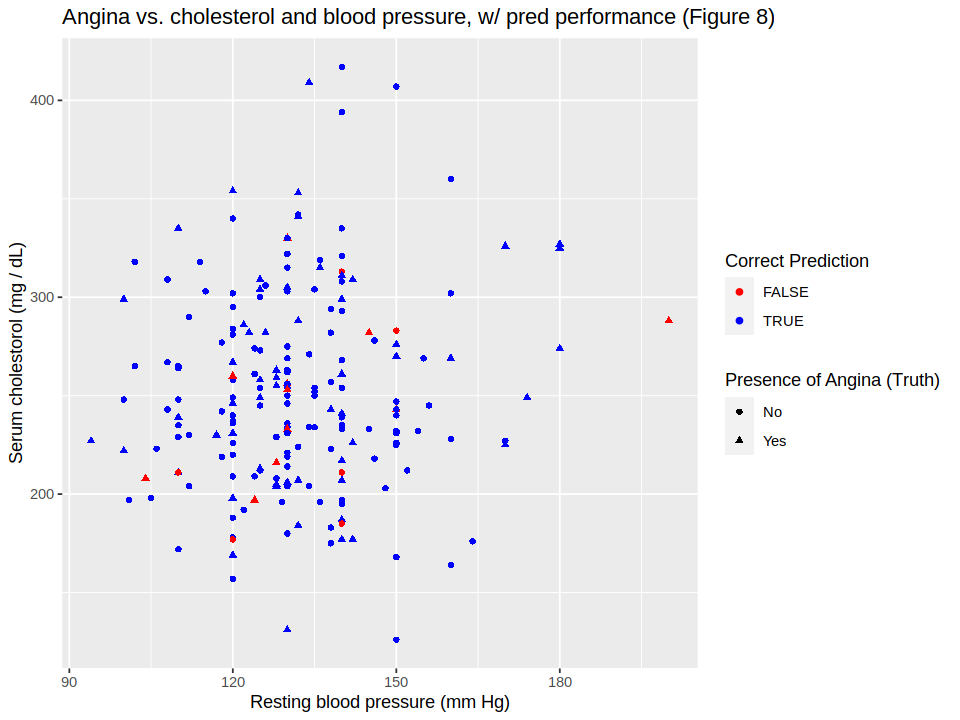

In [14]:
options(repr.plot.width = 8, repr.plot.height = 6)

heart_predictions |> mutate(correct = .pred_class == exang) |>
    ggplot(aes(x = trestbps, y = chol, shape = exang, color = correct)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", shape = "Presence of Angina (Truth)", color = "Correct Prediction") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, w/ pred performance (Figure 8)")

## Discussion

### Findings

Taking into account the context provided in the introduction and the research question, the results are overall quite surprising. With a K value of 3, in order to avoid “ties” in between categories when making a prediction, as well as overfitting, the accuracy rating of the model was 86%, precision was 83% and recall 76%. Considering the fact that only two categories were used to predict the presence of an angina, the results are quite high. The model incorrectly predicted only 35 out of 257 cases, most being false negatives. 

In order to improve the accuracy of the model, other categories would have to be considered. The current available scientific research creates the understanding and expectation that individuals who possess higher values of resting blood pressure and serum cholesterol levels would have a higher incidence of suffering from exercise induced anginas. However, looking at Figures 6 and 7, we notice that a wide range of values exist in both tested categories, and it would not be prudent to conclude that individuals with higher values have a higher incidence of anginas. Individuals in the “yes” category for anginas had both high and low cholesterol and blood pressure, as was the case in those with no anginas detected. Therefore, while the research question is answered favorably, as was seen with the high accuracy ratings, in that cholesterol and blood pressure lead to a model with a high accuracy, these two factors alone are not sufficient to accurately identify if someone is likely to experience an exercise induced angina. 

The applications of such a model are inherently linked to the health field, and could be considered in a clinical context. Nevertheless, when dealing with a patient’s health and treatment plans, no mistakes can be afforded. While such a model might help indicate a problem or be used as a place to start, a hospital or doctor cannot risk misdiagnosing patients through the use of a model, unless it is foolproof. As such, predictive models linked to health areas are more likely to be useful to policy making and governments that can anticipate a population’s health needs and prepare in advance. 

### Impact and Future Questions

Understanding trends of diagnoses is an invaluable asset in the medical field as it can help professionals reach conclusions faster and easier. In the case of heart disease, one of the major impacts such data could improve is the ability to catch heart disease early on in patients, preventing future problems that could prove life threatening.  

Testing different variables in the model such as age, maximum heart rate, and resting heart rate can bring more insight into knowing how angina and heart disease occur, preventing it early on, as well as diagnosing it. This can also bring up much larger questions about how different lifestyles, diets, and habits could contribute to the likelihood of getting heart disease. 

## Bibliography

*Angina*, Heart and Stroke Foundation of Canada, 2023, www.heartandstroke.ca/heart-disease/conditions/angina.

*Angina: Symptoms, Diagnosis and Treatments*, Harvard Health Publishing, 21 Sept. 2021, www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-and-treatments. 

*What Is Angina?*, U.S. Department of Health and Human Services, 23 June 2023, www.nhlbi.nih.gov/health/angina.